In [1]:
import awkward as ak
import dask
import dask_awkward
from distributed import performance_report
import hist
from hist.dask import Hist
import json
from coffea import processor
from coffea.nanoevents import BaseSchema, PFNanoAODSchema, NanoAODSchema
from coffea.dataset_tools import apply_to_dataset, apply_to_fileset, preprocess
from coffea.dataset_tools import max_chunks, max_files, slice_chunks, slice_files
from coffea.analysis_tools import Weights, PackedSelection
import matplotlib.pyplot as plt
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory

/tmp/ipykernel_322135/3704368154.py:14: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [2]:

import fsspec_xrootd


In [3]:
# import uproot
# url = "root://cmsxrootd.fnal.gov//store/group/lpcpfnano/jdickins/v2_2/2018/GluGluHToBB/GluGluHToBB_Pt-200ToInf_M-125_TuneCP5_MINLO_13TeV-powheg-pythia8/GluGluHToBB/220322_131235/0000/nano_mc2018_20.root"
# uproot.open(url)["Events"].show()

In [4]:
# import XRootD.client


In [5]:
from msdprocessor import msdProcessor

In [6]:
# from dask.distributed import Client
# # client = Client("tls://localhost:8786")

# client = Client(n_workers = 10)
# client

In [7]:
from dask.distributed import Client, LocalCluster
cluster= LocalCluster()
cluster.scale(10)
client= Client(cluster)
client

/uscms/home/nyabando/nobackup/miniconda3/envs/fastjet/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34269 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34269/status,
Dashboard: http://127.0.0.1:34269/status,Workers: 10
Total threads: 20,Total memory: 28.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37851,Workers: 10
Dashboard: http://127.0.0.1:34269/status,Total threads: 20
Started: Just now,Total memory: 28.57 GiB
Comm: tcp://127.0.0.1:35703,Total threads: 2
Dashboard: http://127.0.0.1:41465/status,Memory: 2.86 GiB
Nanny: tcp://127.0.0.1:33753,


In [8]:
# with open("2018_GluGluHToBB.json", "rt") as file:
#     initial_fileset = json.load(file)

In [9]:
# import uproot
# initial_fileset = "root://cmsxrootd.fnal.gov//store/group/lpcpfnano/jdickins/v2_2/2018/GluGluHToBB/GluGluHToBB_Pt-200ToInf_M-125_TuneCP5_MINLO_13TeV-powheg-pythia8/GluGluHToBB/220322_131235/0000/nano_mc2018_20.root"
# uproot.open(initial_fileset)["Events"]

In [10]:
with open("2018_GluGluHToBB.json", "rt") as file:
    initial_fileset = json.load(file)

In [11]:
files={}
for i, j in initial_fileset.items():
    print(f"this is i {i}")
    files[i]={"files":{}}
    for k in j:
        # k = k.replace("cmsxrootd.fnal.gov", "xcache")
        files[i]["files"][k] = "Events"
        print(f"this is k {k}")

        # files[i]["files"][k] = "Events"

this is i GluGluHToBB
this is k root://cmsxrootd.fnal.gov//store/group/lpcpfnano/jdickins/v2_2/2018/GluGluHToBB/GluGluHToBB_Pt-200ToInf_M-125_TuneCP5_MINLO_13TeV-powheg-pythia8/GluGluHToBB/220322_131235/0000/nano_mc2018_1-1.root
this is k root://cmsxrootd.fnal.gov//store/group/lpcpfnano/jdickins/v2_2/2018/GluGluHToBB/GluGluHToBB_Pt-200ToInf_M-125_TuneCP5_MINLO_13TeV-powheg-pythia8/GluGluHToBB/220322_131235/0000/nano_mc2018_1.root
this is k root://cmsxrootd.fnal.gov//store/group/lpcpfnano/jdickins/v2_2/2018/GluGluHToBB/GluGluHToBB_Pt-200ToInf_M-125_TuneCP5_MINLO_13TeV-powheg-pythia8/GluGluHToBB/220322_131235/0000/nano_mc2018_10.root
this is k root://cmsxrootd.fnal.gov//store/group/lpcpfnano/jdickins/v2_2/2018/GluGluHToBB/GluGluHToBB_Pt-200ToInf_M-125_TuneCP5_MINLO_13TeV-powheg-pythia8/GluGluHToBB/220322_131235/0000/nano_mc2018_11.root
this is k root://cmsxrootd.fnal.gov//store/group/lpcpfnano/jdickins/v2_2/2018/GluGluHToBB/GluGluHToBB_Pt-200ToInf_M-125_TuneCP5_MINLO_13TeV-powheg-pythia8

In [12]:
# print(files)

In [13]:
preprocessed_available, preprocessed_total = preprocess(
        files,
        step_size=30_000,
        align_clusters=None,
        skip_bad_files=True,
        recalculate_steps=False,
        files_per_batch=1,
        file_exceptions=(OSError,),
        save_form=True,
        uproot_options={},
        step_size_safety_factor=0.5,
    )

In [14]:
import gzip, pickle, json
output_file = "scaleout_fileset"
with gzip.open(f"{output_file}_available.json.gz", "wt") as file:
    json.dump(preprocessed_available, file, indent=2)
    print(f"Saved available fileset chunks to {output_file}_available.json.gz")
with gzip.open(f"{output_file}_all.json.gz", "wt") as file:
    json.dump(preprocessed_total, file, indent=2)
    print(f"Saved complete fileset chunks to {output_file}_all.json.gz")

Saved available fileset chunks to scaleout_fileset_available.json.gz
Saved complete fileset chunks to scaleout_fileset_all.json.gz


In [15]:
test_preprocessed_files = max_files(preprocessed_available, 30)
test_preprocessed = max_chunks(test_preprocessed_files, 30)

In [16]:
# test_preprocessed

In [17]:
compute, results = apply_to_fileset(data_manipulation=msdProcessor(),    
                            fileset=preprocessed_available,
                            schemaclass=PFNanoAODSchema,
                            uproot_options={"allow_read_errors_with_report": (OSError, KeyError)},
                           )

In [18]:
print(compute)

{'GluGluHToBB': {'ExampleHistogram': Hist(
  Regular(15, 450, 1200, name='pt', label='Jet $p_{T}$ [GeV]'),
  Regular(12, -6, 6, name='eta', label='Jet eta'),
  Regular(36, 0, 252, name='msoftdrop', label='Jet msoftdrop'),
  Regular(10, 0, 1, name='n2', label='Jet n2'),
  storage=Weight()) # Sum: WeightedSum(value=0, variance=0) (has staged fills), 'ExampleHistogram1': Hist(
  Regular(10, 0, 1, name='n2b', label='Jet n2b'),
  Regular(36, 0, 252, name='msoftdrop1', label='Jet msoftdrop'),
  storage=Weight()) # Sum: WeightedSum(value=0, variance=0) (has staged fills), 'ExampleHistogram2': Hist(
  Regular(10, 0, 1, name='n2b2', label='Jet n2b2'),
  Regular(36, 0, 252, name='msoftdrop2', label='Jet msoftdrop'),
  storage=Weight()) # Sum: WeightedSum(value=0, variance=0) (has staged fills), 'ExampleHistogram3': Hist(
  Regular(10, 0, 1, name='n2b3', label='Jet n2b3'),
  Regular(36, 0, 252, name='msoftdrop3', label='Jet msoftdrop'),
  storage=Weight()) # Sum: WeightedSum(value=0, variance=0) 

In [19]:
# print(results)

In [20]:
# dir(results)

In [21]:
compute_results=dask.compute(compute)

/uscms/home/nyabando/nobackup/miniconda3/envs/fastjet/lib/python3.12/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/uscms/home/nyabando/nobackup/miniconda3/envs/fastjet/lib/python3.12/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors 

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#----------------------------------------------------------------------

/uscms/home/nyabando/nobackup/miniconda3/envs/fastjet/lib/python3.12/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#----------------------------------------------------------------------

In [22]:
results=dask.compute(results)

In [23]:
print(compute_results)

({'GluGluHToBB': {'ExampleHistogram': Hist(
  Regular(15, 450, 1200, name='pt', label='Jet $p_{T}$ [GeV]'),
  Regular(12, -6, 6, name='eta', label='Jet eta'),
  Regular(36, 0, 252, name='msoftdrop', label='Jet msoftdrop'),
  Regular(10, 0, 1, name='n2', label='Jet n2'),
  storage=Weight()) # Sum: WeightedSum(value=11372, variance=5366.5) (WeightedSum(value=11642.8, variance=5494.26) with flow), 'ExampleHistogram1': Hist(
  Regular(10, 0, 1, name='n2b', label='Jet n2b'),
  Regular(36, 0, 252, name='msoftdrop1', label='Jet msoftdrop'),
  storage=Weight()) # Sum: WeightedSum(value=11574.8, variance=5462.21) (WeightedSum(value=11642.8, variance=5494.26) with flow), 'ExampleHistogram2': Hist(
  Regular(10, 0, 1, name='n2b2', label='Jet n2b2'),
  Regular(36, 0, 252, name='msoftdrop2', label='Jet msoftdrop'),
  storage=Weight()) # Sum: WeightedSum(value=11575.3, variance=5462.43) (WeightedSum(value=11642.8, variance=5494.26) with flow), 'ExampleHistogram3': Hist(
  Regular(10, 0, 1, name='n2b

In [24]:
h=compute_results[0]["GluGluHToBB"]["ExampleHistogram"]

In [25]:
print(h)

Hist(
  Regular(15, 450, 1200, name='pt', label='Jet $p_{T}$ [GeV]'),
  Regular(12, -6, 6, name='eta', label='Jet eta'),
  Regular(36, 0, 252, name='msoftdrop', label='Jet msoftdrop'),
  Regular(10, 0, 1, name='n2', label='Jet n2'),
  storage=Weight()) # Sum: WeightedSum(value=11372, variance=5366.5) (WeightedSum(value=11642.8, variance=5494.26) with flow)


In [26]:
print(type(h))

<class 'hist.hist.Hist'>


In [27]:
h1= compute_results[0]["GluGluHToBB"]["ExampleHistogram1"]

In [28]:
h2= compute_results[0]["GluGluHToBB"]["ExampleHistogram2"]

In [29]:
h3= compute_results[0]["GluGluHToBB"]["ExampleHistogram3"]

In [30]:
h4= compute_results[0]["GluGluHToBB"]["ExampleHistogram4"]

In [31]:
h5= compute_results[0]["GluGluHToBB"]["ExampleHistogram5"]

NameError: name 'np' is not defined

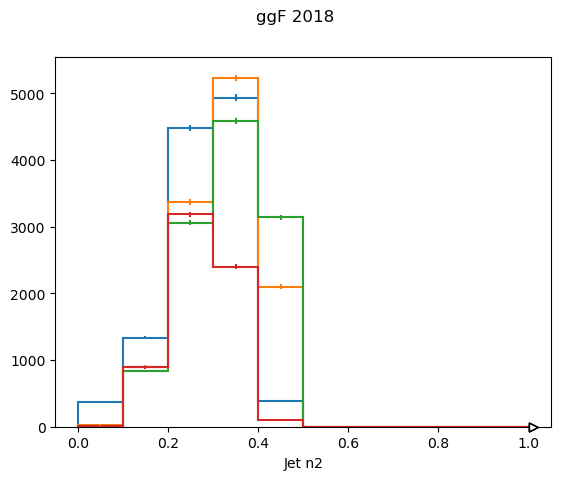

In [46]:
h[{'eta':sum, 'pt':sum, 'msoftdrop':sum}].plot1d(label="beta=0")
h1[{'msoftdrop1':sum}].plot1d(label="beta=1")
h2[{'msoftdrop2':sum}].plot1d(label="beta=2")
h3[{'msoftdrop3':sum}].plot1d(label="beta=-0.5")
plt.suptitle('ggF 2018')



plt.legend()


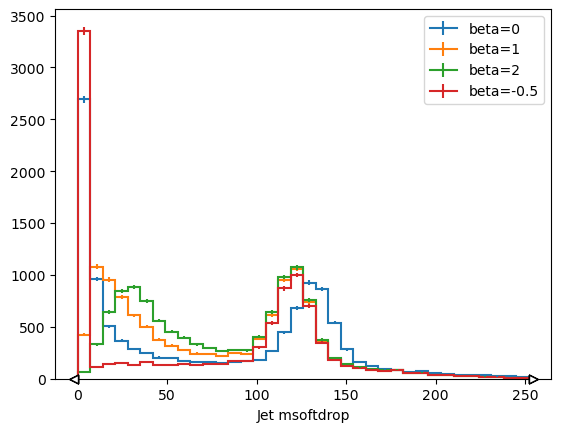

In [33]:
h[{'eta':sum, 'pt':sum, 'n2':sum}].plot1d(label="beta=0")
h1[{'n2b':sum}].plot1d(label="beta=1")
h2[{'n2b2':sum}].plot1d(label="beta=2")
h3[{'n2b3':sum}].plot1d(label="beta=-0.5")

plt.legend()

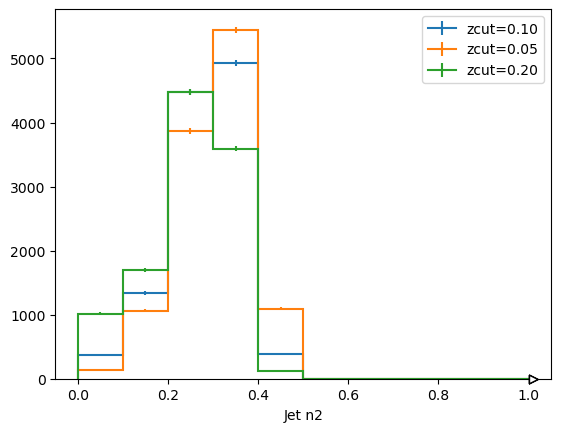

In [34]:
h[{'eta':sum, 'pt':sum, 'msoftdrop':sum}].plot1d(label="zcut=0.10")
h4[{'msoftdropz1':sum}].plot1d(label="zcut=0.05")
h5[{'msoftdropz2':sum}].plot1d(label="zcut=0.20")

plt.legend()

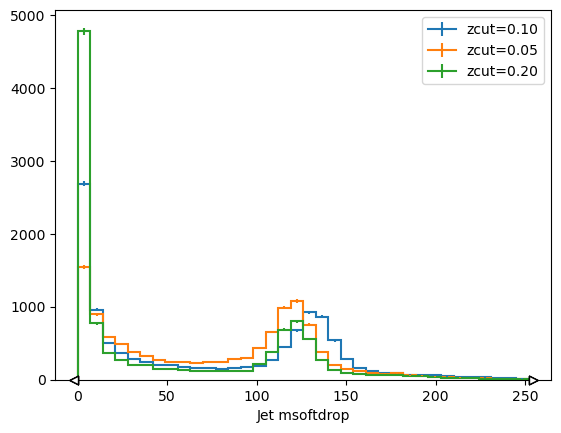

In [35]:
h[{'eta':sum, 'pt':sum, 'n2':sum}].plot1d(label="zcut=0.10")
h4[{'n2z1':sum}].plot1d(label="zcut=0.05")
h5[{'n2z2':sum}].plot1d(label="zcut=0.20")


plt.legend()

In [36]:
# from coffea.analysis_tools import Weights

In [37]:
# Weights?

In [38]:
# def analysis(df):
#     processor_instance = msdProcessor(isMC=True)
#     result = processor_instance.process(df)
#     return result

In [39]:
# df = compute

In [40]:
# results = dask.delayed(analysis)(df)
# final_result = dask.compute(results)

In [41]:
#result_compute

In [42]:
tg_result = dask.compute(tg)
rep_result = dask.compute(rep)

NameError: name 'tg' is not defined